# Notebook to analyze the data from AGNs catalogs

We want to analyze multiwavelength data from several AGNs.  
In order to do that, we have compiled data from $18023$ sources.  
They have been retrieved from the review from **Inayoshi et al., 2020**, 
the `COSMOS` catalog  
(`VLA-COSMOS 3 GHz Large Project`; **Smolčić et al. 2017**), and from  
the Million Quasar Catalog (`Milliquas`; **Flesch, 2019**) combined with the  
cross-matching between `SDSS QUASAR DR12` catalog and `FIRST` observations.  
Additional observations were also added from the `radio` database catalog,  
compiled by NASA's `HEASARC` team.

In this way, we select sources with observations in radio frequencies.

---

## Python setup

First, we import the packages to be used

To get the first line working, you need  
to run the following lines:

```bash
 conda install nodejs
 pip install ipympl
 pip install --upgrade jupyterlab
 jupyter labextension install @jupyter-widgets/jupyterlab-manager
 jupyter labextension install jupyter-matplotlib
 jupyter nbextension enable --py widgetsnbextension
 ```

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# from matplotlib.ticker import FormatStrFormatter
# from matplotlib.patches import Polygon
# from astropy.io import fits
# from astropy.table import Table
# from astropy.table import Column
# from astropy.table import MaskedColumn
# from astropy.table import hstack
# from astropy.table import vstack
# from astropy.table import join
# from astropy.wcs import WCS
from astropy import units as u
from astropy.visualization import hist
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
# from astroquery.simbad import Simbad
# from astroquery.ned import Ned
from scipy.cluster import hierarchy as hc
from scipy.spatial import distance
from sklearn.impute import SimpleImputer
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import getpass
import progressbar
import pandas as pd
from pandas.plotting import scatter_matrix
import re
import missingno as msno
import itertools

Define the spectral index $\alpha$ from different sources  
to be used in the luminosity calculations (K-correction)

In [2]:
alpha_first = 0.5  # From FIRST data (Bornancini+2010)
alpha_RG    = 1.0  # For radio galaxies (Verkhodanov & Khabibullina, 2010)
alpha_alex  = 0.8  # Star-forming galaxies (Alexander+2003)
alpha_smol  = 0.7  # Mean value from VLA-COSMOS 3GHz sample (Smolčić et al. 2017)
alpha_butl  = 0.75  # From Butler et al., 2018

Choose one of the spectral indexes

In [3]:
alpha_used  = alpha_butl

We define the cosmological properties to calculate luminosity distances and other quantities.

In [4]:
cosmo       = FlatLambdaCDM(H0=70, Om0=0.3)

In [5]:
def lum_from_flux(flux, redshift):  # Flux in mJy
    lum_distance = cosmo.luminosity_distance(redshift).to(u.m).value  # in m
    luminosity   = 4 * np.pi * lum_distance**2 * flux * 1e-3  * 1e-26 * (1 + redshift)**(alpha_used - 1)  # in W/Hz
    return luminosity

Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [6]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

---

## Reading data

In [7]:
machine  = getpass.getuser()
# cat_path = '/home/' + machine + '/Documentos/Data/'
cat_path = ''  # relative path to the same directory

We import our data using the `pandas` package.  

It is important to keep in mind that columns with keys starting with `Flux Density...` are in `Jy`.  
All the other values, are expressed in `mJy`.

Columns with uncertainties (`NED Uncertainty...`) have been saved as strings, to preserve possible upper limits.

In [8]:
large_catalog_df = pd.read_hdf(cat_path + 'large_cat_simbad_inayoshi_ned.h5', 'df')

Data could be also converted into `astropy` Tables.

In [9]:
# large_catalog_tab = Table.from_pandas(large_catalog_df)

It is possible to save column names into a plain text file to keep track of them.

In [10]:
# np.savetxt(cat_path + 'column_names_flx.txt', large_catalog_df.columns, fmt='%s', delimiter='\n')

From the querying process, some columns have the same identifier.  
In those cases, the suffix `_x` or `_y` has been added (`_x` for `simbad` data, and `_y` for `Ned` photometry).
One example is shown below.

In [11]:
# large_catalog_df.loc[90:100, ['MAIN_ID_x', 'MAIN_ID_y']]

---

## Organize data

Separate data into different arrays for calculations

Repeated keywords are: `MAIN_ID_x`, `MAIN_ID_y`, `COORD_x`, and `COORD_y`

The following redshift column comes from `SDSS` with the highest quality flag selected.

In [12]:
redshift    = large_catalog_df['Z_OWN']
redshift_e  = large_catalog_df['Z_OWN_ERR']
L_20cm      = large_catalog_df['L_20CM']
L_20cm_e    = large_catalog_df['L_20CM_ERR']
L_20cm_up_l = large_catalog_df['L_20CM_UP_LIM']

We can calculate luminosities from fluxes.

In this case, we first select the columns with fluxes in a numerical format  
(with this all error columns are discarded for the moment).

In [13]:
numeric_col_names = large_catalog_df.select_dtypes('number').columns.drop(['INDEX', 'RA_d', 'DEC_d', 'Z_VALUE', 'FLUX_ERROR_B',\
                                                                           'Z_OWN_ERR', 'L_20CM', 'L_20CM_ERR', 'L_250GHZ', 'L_250GHZ_ERR',\
                                                                           'F_20CM_ERR', 'F_250GHZ_ERR', 'MASS_1450', 'FLUX_ERROR_V',\
                                                                           'FLUX_ERROR_R', 'FLUX_ERROR_I','FLUX_ERROR_J',\
                                                                           'FLUX_ERROR_K', 'Z_OWN'])
#numeric_col_names = large_catalog_df.select_dtypes('number').columns.drop(['INDEX', 'RA_d', 'DEC_d', 'Z_VALUE', 'D_LUM', 'FLUX_ERROR_B',\
#                                                                           'Z_OWN_ERR', 'L_20CM', 'L_20CM_ERR', 'L_250GHZ', 'L_250GHZ_ERR',\
#                                                                           'F_20CM_ERR', 'F_250GHZ_ERR', 'MASS_1450', 'FLUX_ERROR_V',\
#                                                                           'FLUX_ERROR_R', 'FLUX_ERROR_I','FLUX_ERROR_J',\
#                                                                           'FLUX_ERROR_K', 'JOINED_F_14GHZ', 'TEST_14_LUM',\
#                                                                           'Z_OWN'])

We create a new `pandas` `DataFrame` object to contain our luminosities,  
and we calculate them taking into account the difference in units for some of the  
columns with fluxes.

In [14]:
lums_catalog_df                       = pd.DataFrame()

In [15]:
for col_name in numeric_col_names:
    if 'F_' in col_name:
        lum_col_name                  = col_name.replace('F_', 'LUMINOSITY_')
        lums_catalog_df[lum_col_name] = lum_from_flux(large_catalog_df[col_name], redshift)
    if 'FLUX_' in col_name:
        lum_col_name                  = col_name.replace('FLUX_', 'LUMINOSITY_')
        lums_catalog_df[lum_col_name] = lum_from_flux(large_catalog_df[col_name], redshift)
    if 'Flux Density' in col_name:
        lum_col_name                  = col_name.replace('Flux Density', 'Luminosity')
        lums_catalog_df[lum_col_name] = lum_from_flux(large_catalog_df[col_name] * 1e3, redshift) 

For future use and reference, we can add new columns to the original catalog. 

In [16]:
lf_catalog_cols = lums_catalog_df.columns

One such column contains luminosity distances calculated from redshift values.

In [17]:
large_catalog_df['D_LUM']           = cosmo.luminosity_distance(large_catalog_df['Z_OWN']).to(u.m).value

Our catalog contains several columns with observations in very similar  
frequencies and configurations.  
As a way to gather them, we can create a new column with the **average**  
(in `mJy`) of all the $1.4$ GHz fluxes. 

In [18]:
large_catalog_df['F_1.4GHZ_average'] = (large_catalog_df[['Flux Density 1.4GHz', 'Flux Density 1.40 GHz',\
                                'Flux Density 1.4 GHz', 'Flux Density 1420.5 MHz',\
                                'Flux Density 1.42 GHz', 'Flux Density 1425 MHz',\
                                'Flux Density 1410 MHz', 'Flux Density 1.4 GHz VLA B-array']].mean(axis=1) * 1e3 + large_catalog_df['F_20CM']) / 2

From this new column, luminosities can be obtained and added to the recently created table.

In [19]:
# joined_lum_14GHz = lum_from_flux(large_catalog_df['JOINED_F_14GHZ'], redshift)
lums_catalog_df['LUMINOSITY_1.4GHZ_average'] = lum_from_flux(large_catalog_df['F_1.4GHZ_average'], redshift)

As before, we can create a file to save the names of this new table with luminosities

In [20]:
# np.savetxt(cat_path + 'column_names_lum.txt', lums_catalog_df.columns, fmt='%s', delimiter='\n')

Only for calculation purposes, we can show the luminosity columns with the ($10$) highest number of elements.

In [21]:
stats_lums  = pd.DataFrame(lums_catalog_df.describe().loc['count'])
counts_lums = stats_lums.sort_values('count', ascending=False)
counts_lums[:10]

,count
LUMINOSITY_20CM,17957.0
Luminosity W1,10393.0
Luminosity i,10174.0
Luminosity z,10075.0
Luminosity r,10066.0
Luminosity g,10057.0
Luminosity u,10021.0
Luminosity W2,9800.0
LUMINOSITY_V,9166.0
LUMINOSITY_B,9062.0


We can also attempt to merge the values from some columns. This can be done with features  
observed in similar (or equal) frequencies.

In order to do this, we can first import a list of all the used Passbands used in our table  
with their frequencies (Only measurements from `Ned`).

In [22]:
band_names = np.loadtxt(cat_path + 'all_ned_band_names.txt', usecols=[0], dtype=np.str, delimiter='\t')
band_freqs = np.loadtxt(cat_path + 'all_ned_band_names.txt', usecols=[1], dtype=np.float, delimiter='\t')

These bands can be ordered by observed frequency.

In [23]:
band_names_ord    = band_names[np.argsort(band_freqs)]
band_freqs_ord    = np.sort(band_freqs)
band_freqs_ord_2d = np.c_[band_freqs_ord, np.zeros_like(band_freqs_ord)]  # Make it a 2-D array for future calculations

Repeat procedure used to obtain data table: join features with almost identical passband names.

In [24]:
band_names_ord_rep = []
for band_name in band_names_ord:
    band_names_ord_rep.append(' '.join(re.findall(r'[A-Za-z]+|\d*[.,-]?\d+', re.sub(r' \(.*', '', str(band_name)).strip())))

In [25]:
band_names_ord_rep_small = []
band_freqs_ord_rep_small = []
for index, band_name in enumerate(band_names_ord_rep):
    if band_name not in band_names_ord_rep_small:
        if band_freqs_ord[index] not in band_freqs_ord_rep_small:
            band_names_ord_rep_small.append(band_name)
            band_freqs_ord_rep_small.append(band_freqs_ord[index])

In [26]:
band_names_freqs_ord_merged = pd.Series(band_freqs_ord_rep_small, index=band_names_ord_rep_small)

Calculate pair-wise distance among all frequencies (output is a matrix)

In [27]:
band_freqs_dists  = pd.DataFrame(data=distance.squareform(distance.pdist(band_freqs_ord_2d, metric='euclidean')),\
                                index=band_names_ord, columns=band_names_ord)

Group features with similar names and frequencies very close to each other.

In [28]:
band_names_groups_orig  = []
band_names_groups_repl  = []
used_band_names         = []
for index, band_name in enumerate(band_names_ord):
    str_to_search = ' '.join(re.findall(r'[A-Za-z]+|\d*[.,-]?\d+', re.sub(r' \(.*', '', str(band_name)).strip()))
    if band_name not in list(itertools.chain.from_iterable(band_names_groups_orig)) and str_to_search not in used_band_names:
        used_band_names.append(str_to_search)
        filter_dist = (band_freqs_dists[band_name] < 2.5)  # 2.5 % difference between band frequencies
        if np.ndim(filter_dist) > 1:
            filter_dist = filter_dist.iloc[:, 0]
        band_names_groups_orig.append(band_names_ord[filter_dist].tolist())
        band_names_groups_repl.append(['Luminosity ' + re.sub(r' \(.*', '', name).strip()\
                                       for name in band_names_ord[filter_dist].tolist()\
                                      if 'Luminosity ' + re.sub(r' \(.*', '', name).strip() in lf_catalog_cols])

Create new table with luminosities. Features from the previously defined groups will be averaged and saved as  
one single column.

In [29]:
merged_lums_catalog_df = pd.DataFrame()
for element in band_names_groups_repl:
    # lums_catalog_df[np.unique(band_names_groups_repl[0], axis=0)].describe()
    test_table = lums_catalog_df[np.unique(element, axis=0)].median(axis='columns', skipna=True)
    # test_table = test_table.rename(np.unique(element, axis=0)[0])
    merged_lums_catalog_df[np.unique(element, axis=0)[0]] = test_table

Incorporate luminosities from `SIMBAD` measurements and from initial **Inayoshi et al., 2020** catalog.

The columns `large_catalog_df['L_20CM']` and `lums_catalog_df['LUMINOSITY_20CM']` have the same  
number of elements and have the same values. But they have been calculated in different moments.

In [30]:
# hc.loc[hc["ID"].isnull(),'ID'] = hc["First Name"] + hc["Last Name"]

Keep $1.4$ GHz observations over `Ned` data.

In [31]:
# replace_20cm = np.nanmedian([merged_lums_catalog_df['Luminosity 1.4 GHz'].values, large_catalog_df['L_20CM'].values], axis=0)
# merged_lums_catalog_df['Luminosity 1.4 GHz'].replace(replace_20cm, inplace=True)

merged_lums_catalog_df.loc[~large_catalog_df['L_20CM'].isnull(), 'Luminosity 1.4 GHz'] = large_catalog_df['L_20CM']

In [32]:
replace_B_band = np.nanmedian([merged_lums_catalog_df['Luminosity B'].values, lums_catalog_df['LUMINOSITY_B'].values], axis=0)
merged_lums_catalog_df['Luminosity B'].replace(replace_B_band, inplace=True)

/home/rcarvajal/.anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [33]:
replace_V_band = np.nanmedian([merged_lums_catalog_df['Luminosity V'].values, lums_catalog_df['LUMINOSITY_V'].values], axis=0)
merged_lums_catalog_df['Luminosity V'].replace(replace_V_band, inplace=True)

In [34]:
replace_R_band = np.nanmedian([merged_lums_catalog_df['Luminosity R'].values, lums_catalog_df['LUMINOSITY_R'].values], axis=0)
merged_lums_catalog_df['Luminosity R'].replace(replace_R_band, inplace=True)

In [35]:
replace_I_band = np.nanmedian([merged_lums_catalog_df['Luminosity I'].values, lums_catalog_df['LUMINOSITY_I'].values], axis=0)
merged_lums_catalog_df['Luminosity I'].replace(replace_I_band, inplace=True)

In [36]:
replace_J_band = np.nanmedian([merged_lums_catalog_df['Luminosity J'].values, lums_catalog_df['LUMINOSITY_J'].values], axis=0)
merged_lums_catalog_df['Luminosity J'].replace(replace_J_band, inplace=True)

In [37]:
replace_K_band = np.nanmedian([merged_lums_catalog_df['Luminosity K'].values, lums_catalog_df['LUMINOSITY_J'].values], axis=0)
merged_lums_catalog_df['Luminosity K'].replace(replace_J_band, inplace=True)

In [38]:
replace_250GHz = np.nanmedian([merged_lums_catalog_df['Luminosity 1300 microns'].values, lums_catalog_df['LUMINOSITY_250GHZ'].values], axis=0)
merged_lums_catalog_df['Luminosity 1300 microns'].replace(replace_250GHz, inplace=True)

---

## Plot initial values

We create an initial plot of $1.4$ GHz vs. redshift ($z$) for our sources.

Fix fluxes are added for ease of comprehension.

In [39]:
z_range        = np.arange(0, 10.2, 0.25)  # array to be used in other instances
lum_dist_range = cosmo.luminosity_distance(z_range).to(u.m).value  # in m

In [40]:
lum_FIRST      = 4 * np.pi * lum_dist_range**2 * 1e-3  * 1e-26 * (1 + z_range)**(alpha_used - 1)
lum_50uJy      = 4 * np.pi * lum_dist_range**2 * 50e-6 * 1e-26 * (1 + z_range)**(alpha_used - 1)
lum_20uJy      = 4 * np.pi * lum_dist_range**2 * 20e-6 * 1e-26 * (1 + z_range)**(alpha_used - 1)
lum_10uJy      = 4 * np.pi * lum_dist_range**2 * 10e-6 * 1e-26 * (1 + z_range)**(alpha_used - 1)
lum_5uJy       = 4 * np.pi * lum_dist_range**2 * 5e-6  * 1e-26 * (1 + z_range)**(alpha_used - 1)
lum_1uJy       = 4 * np.pi * lum_dist_range**2 * 1e-6  * 1e-26 * (1 + z_range)**(alpha_used - 1)

In [41]:
cmap           = cm.get_cmap('inferno')
dark_color     = cmap(0.4)  # RGBA color code
light_color    = cmap(0.6)  # RGBA color code
colors         = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_8       = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]

In [42]:
pe1            = [mpe.Stroke(linewidth=3, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

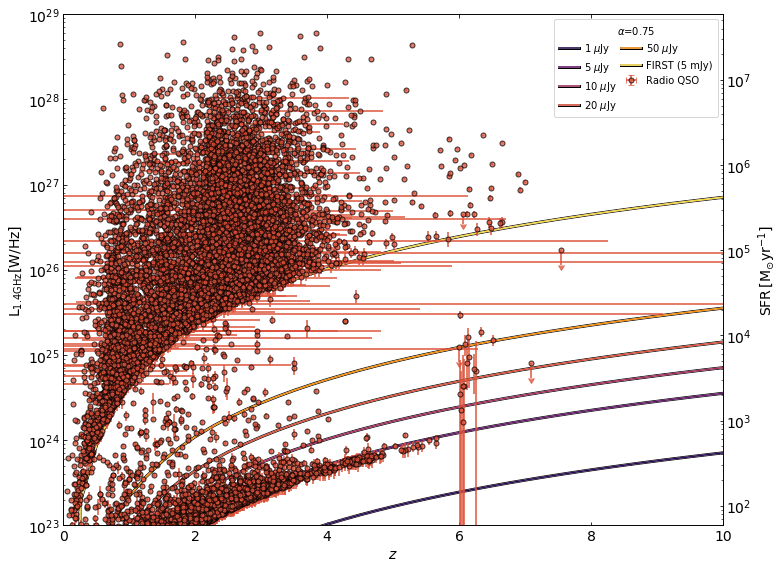

In [43]:
fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)

ax1.errorbar(redshift, merged_lums_catalog_df['Luminosity 1.4 GHz'], xerr=redshift_e, yerr=L_20cm_e, marker='.', ls='', color=colors[3], markersize=10, zorder=7, alpha=0.75, uplims=L_20cm_up_l, elinewidth=2, mec='k', label='Radio QSO')
# ax1.errorbar(redshift, L_20cm, xerr=redshift_e, yerr=L_20cm_e, marker='.', ls='', color=colors[4], markersize=10, zorder=7, alpha=0.75, uplims=L_20cm_up_l, elinewidth=2, mec='k', label='Radio QSO')

#ax1.errorbar(high_z_zs[filter_250GHz], lum_250_new_alpha_rescale[filter_250GHz], yerr=lum_250_new_alpha_rescale_e[filter_250GHz], marker='P', ls='', color=colors[4], markersize=10, zorder=7, alpha=0.65, uplims=high_z_up_lim[filter_250GHz], elinewidth=2, mec='k', label='mm QSO')

ax1.plot(z_range, lum_1uJy, label='1 $\mu$Jy', color=colors[0], path_effects=pe1)
ax1.plot(z_range, lum_5uJy, label='5 $\mu$Jy', color=colors[1], path_effects=pe1)
ax1.plot(z_range, lum_10uJy, label='10 $\mu$Jy', color=colors[2], path_effects=pe1)
ax1.plot(z_range, lum_20uJy, label='20 $\mu$Jy', color=colors[3], path_effects=pe1)
ax1.plot(z_range, lum_50uJy, label='50 $\mu$Jy', color=colors[4], path_effects=pe1)
ax1.plot(z_range, lum_FIRST, label='FIRST (5 mJy)', color=colors[5], path_effects=pe1)
#ax1.plot(z_range, SFR_3000, label='3000M_sun/yr', color=colors[2], path_effects=pe1)
#ax1.fill_between(z_range, SFR_3000 - SFR_3000_e, SFR_3000 + SFR_3000_e, color=colors[2], fc=colors[2], alpha=0.3, zorder=6)
#gradient_fill(z_range, max_pow_sfr_fix + 3 * max_pow_sfr_fix_e, fill_color=colors[4], color=colors[4], label='SFR - fixed M', zorder=5, ax=ax1)
#ax1.plot(z_range, max_pow_sfr_fix, '-', color=colors[4], alpha=0.45)
#gradient_fill(z_range, max_pow_sfr + 3 * max_pow_sfr_e, fill_color=colors[3], color=colors[3], label='SFR - evolv. M', zorder=5, ax=ax1)
#ax1.plot(z_range, max_pow_sfr, '-', color=colors[3], alpha=0.45)
ax1.set_xlabel('$z$', size=14)
ax1.set_ylabel('$\mathrm{L}_{1.4 \mathrm{GHz}} [\mathrm{W/Hz}]$', size=14)
ax1.set_yscale('log')
ax1.set_ylim((1e23, 1e29))
ax1.set_xlim(left=-0.001, right=10)
#ax1.set_xlim(left=5.5, right=8)
ax1.legend(loc=1, title=f'{alp_str}={alpha_used}', ncol=2, labelspacing=0.5, borderpad=0.5, columnspacing=0.5, handletextpad=0.5)


ax2 = ax1.twinx()
ax2.set_ylabel('$\mathrm{SFR}\, [\mathrm{M}_{\odot} \mathrm{yr}^{-1}]$', size=14)
ax2.set_ylim((1e23 * 5.9e-22, 1e29 * 5.9e-22))
ax2.set_yscale('log')
ax2.figure.canvas.draw()

#plt.setp(ax2.get_yticklabels(), visible=False)
ax1.tick_params(which='both',top=True, right=False, direction='in')
ax2.tick_params(which='both',top=True, right=True, direction='in', labelright=True)

ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
fig.tight_layout(w_pad=0.01)

We can see a very noticeable gap in our source distribution.
From the calculations in **Amarantidis et al., 2019**, we can explain this behavior  
from the selection biases of the different surveys involved in the production of our catalog. 

---

# Plot individual features

Another option to display the data is using histograms.  
From the selection of one column, we can create a plot.

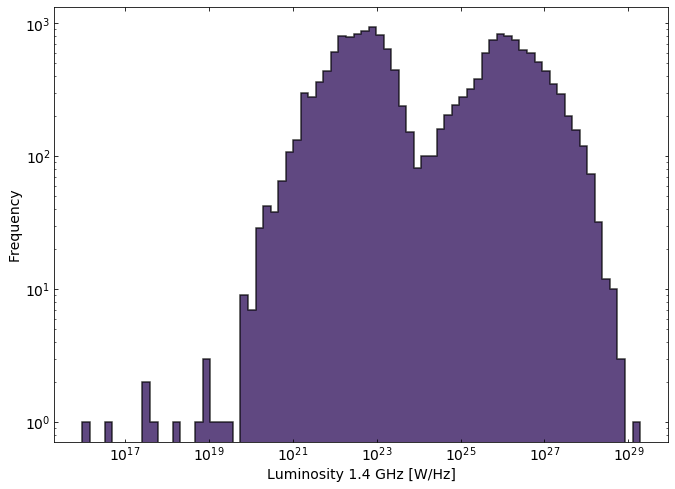

In [44]:
fig          = plt.figure(figsize=(11,8))
ax1          = fig.add_subplot(111)

col_name     = 'Luminosity 1.4 GHz'
col_name_str = col_name + ' [W/Hz]'

vmin_L       = np.log10(merged_lums_catalog_df[col_name].min())
vmax_L       = np.log10(merged_lums_catalog_df[col_name].max())
bins_L       = np.logspace(vmin_L, vmax_L, 75)

ax1.set_xscale('log')
ax1.set_yscale('log')
# ax1.set_xlabel('$\mathrm{L}_{1.4 \mathrm{GHz}} [\mathrm{W/Hz}]$', size=14)
ax1.set_xlabel(col_name_str, size=14)
ax1.set_ylabel('$\mathrm{Frequency}$', size=14)
ax1.tick_params(which='both',top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
merged_lums_catalog_df[col_name].plot.hist(color=colors[0], alpha=0.75, bins=bins_L, histtype='stepfilled', ec='k', lw=1.5)

For completeness, we can also create a histogram for the available redshift values.

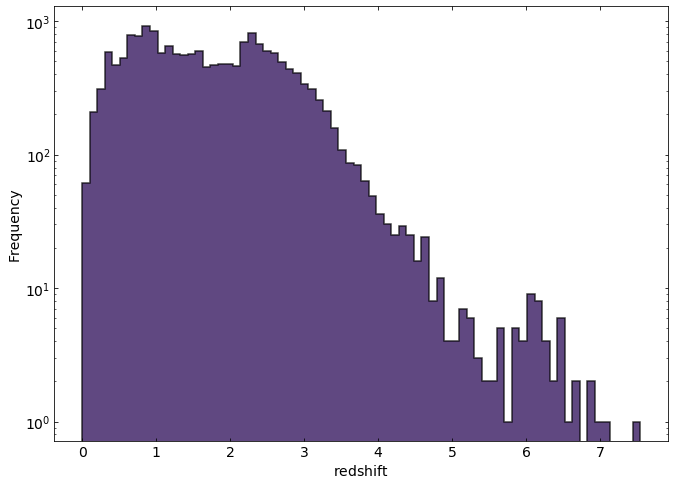

In [45]:
fig    = plt.figure(figsize=(11,8))
ax1    = fig.add_subplot(111)

vmin_z = redshift.min()
vmax_z = redshift.max()
bins_z = np.linspace(vmin_z, vmax_z, 75)

# ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('$\mathrm{redshift}$', size=14)
ax1.set_ylabel('$\mathrm{Frequency}$', size=14)
ax1.tick_params(which='both',top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
redshift.plot.hist(color=colors[0], alpha=0.75, bins=bins_z, histtype='stepfilled', ec='k', lw=1.5)

We can also select two luminosity columns and plot them. We can color-code them by redshift  
and include histograms for both quantities.

In [46]:
lum_names           = merged_lums_catalog_df.columns

In [47]:
add_histograms_flag = True  # Add histograms to the folowing plot

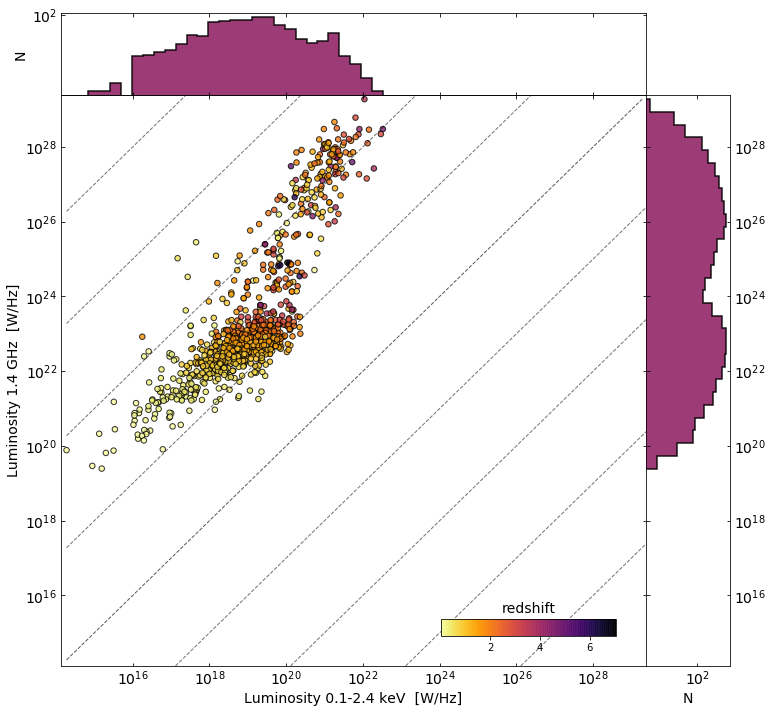

In [48]:
fig        = plt.figure(figsize=(12,12))

if not add_histograms_flag:
    ax1    = fig.add_subplot(111)

if add_histograms_flag:
    ax1    = plt.subplot2grid((8,8), (1,0), colspan=7, rowspan=7)
    ax2    = plt.subplot2grid((8,8), (1,7), sharey=ax1, rowspan=7, colspan=1)
    ax3    = plt.subplot2grid((8,8), (0,0), sharex=ax1, colspan=7, rowspan=1)

# Select columns by number
# col_a = lum_names[0]
# col_b = lum_names[23]

# Select columns by name
col_a       = "Luminosity 0.1-2.4 keV"
col_b       = "Luminosity 1.4 GHz"

# Obtain luminosities and the cross-match between them
lum_a       = merged_lums_catalog_df[col_a]
lum_b       = merged_lums_catalog_df[col_b]
common_vals = np.multiply(lum_a, lum_b)

# Create log bins for log-scale histograms
min_val     = np.nanmin([lum_a[np.isfinite(common_vals)].min(), lum_b[np.isfinite(common_vals)].min()])
max_val     = np.nanmax([lum_a[np.isfinite(common_vals)].max(), lum_b[np.isfinite(common_vals)].max()])
bins_a      = np.logspace(np.log10(lum_a[np.isfinite(common_vals)].values.min()), np.log10(lum_a[np.isfinite(common_vals)].values.max()), 30)
bins_b      = np.logspace(np.log10(lum_b[np.isfinite(common_vals)].values.min()), np.log10(lum_b[np.isfinite(common_vals)].values.max()), 30)

ax1.set_yscale('log')
ax1.set_xscale('log')

# Format axis names and limits
if 'LUMINOSITY_' in col_a:
    col_a   = col_a.replace('LUMINOSITY_', 'Luminosity ') + ' (SIMBAD)'
if 'LUMINOSITY_' in col_b:
    col_b   = col_b.replace('LUMINOSITY_', 'Luminosity ') + ' (SIMBAD)'
ax1.set_xlabel(col_a + '  [W/Hz]', size=14)
ax1.set_ylabel(col_b + '  [W/Hz]', size=14)
ax1.set_ylim(min_val*0.7, max_val*1.3)
ax1.set_xlim(min_val*0.7, max_val*1.3)
ax1.tick_params(which='both',top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)

sc          = ax1.scatter(lum_a, lum_b, c=redshift, cmap='inferno_r', s=30, alpha=0.80, edgecolor='black')

# Add 1-1 line and parallels for comparison
ax1.plot([min_val, max_val], [min_val, max_val], ls='dashed', color='k', alpha=0.65, lw=1)
for factor in [1e3, 1e6, 1e9, 1e12]:
    ax1.plot([min_val, max_val], [min_val*factor, max_val*factor], ls='dashed', color='k', alpha=0.55, lw=1)
    ax1.plot([min_val, max_val*factor], [min_val/factor, max_val], ls='dashed', color='k', alpha=0.55, lw=1)

# Create colorbar and plot it
cbaxes      = inset_axes(ax1, width="30%", height="3%", loc=4, borderpad=3) 
clb         = plt.colorbar(sc, cax=cbaxes, orientation='horizontal')
# clb.set_label('redshift', size=14)
clb.ax.set_title('redshift', size=14)

ax1.set_aspect('auto', share=False, adjustable='box')

if add_histograms_flag:
    # Plot vertical histogram
    hist(lum_b.values, bins=bins_b, orientation='horizontal', ax=ax2, histtype='stepfilled', alpha=0.9, color=dark_color, ec='k', lw=1.5, hatch='')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('N', size=14)
    
    # Plot horizontal histogram
    hist(lum_a.values, bins=bins_a, orientation='vertical', ax=ax3, histtype='stepfilled', alpha=0.9, color=dark_color, ec='k', lw=1.5, hatch='')
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.set_ylabel('N', size=14)
    
    # Modify ticks
    ax2.tick_params(axis='both', which='major', labelsize=14)
    ax3.tick_params(axis='both', which='major', labelsize=14)
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.setp(ax3.get_xticklabels(), visible=False)
    ax2.tick_params(which='both',top=True, right=True, direction='in', labelright=True)
    ax3.tick_params(which='both',top=True, right=True, direction='in')
    
    plt.subplots_adjust(wspace=0.0, hspace=0.0)

Another visualization option considers obtaining a kernel density estimation (`kde`) for the  
distribution of each column (luminosity). The tools of `pandas` allow us to do this.

(1e-50, 1.3230173204364813e-27)

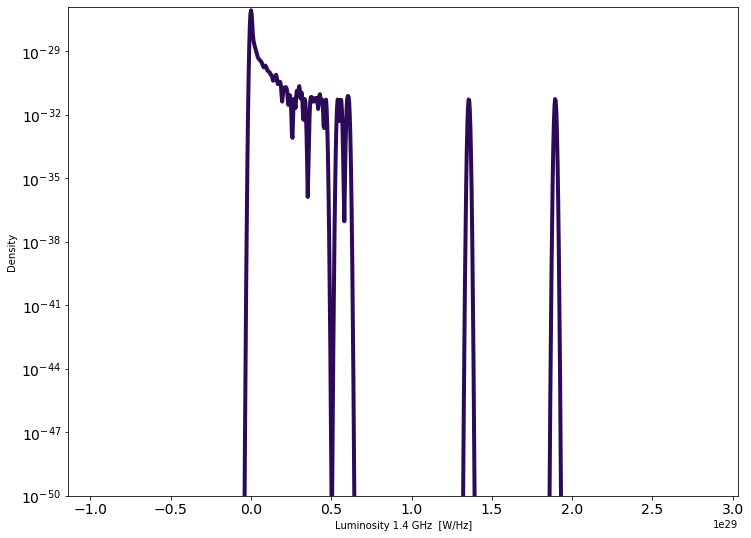

In [49]:
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)

# Choose the column to use (from highly correlated luminosities)
# used_col_num = 2
# used_col     = cols_high_corr[used_col_num]

# Choose directly the column name
used_col     = "Luminosity 1.4 GHz"

merged_lums_catalog_df[used_col].plot.kde(ax=ax1, fontsize=14, logy=True, ylim=(1e-50, None), color=colors[0], lw=4)
ax1.set_xlabel(used_col + '  [W/Hz]');
ax1.set_ylim((1e-50, ax1.lines[0].get_data()[1].max() * 1.5))
# ax1.set_xlim((ax1.lines[0].get_data()[0].min(), ax1.lines[0].get_data()[0].max()))

This plot can be extended into a scatter matrix which shows individual distributions (`kde`) and pair-wise plots.  
In our case, and given the need of using logarithmic scales for the axes, the plots do not show completely well.  
We leave the code block but without being executed.

In [50]:
# # fig = plt.figure(figsize=(12,9))
# # ax1 = fig.add_subplot(111)

# axl = scatter_matrix(lums_catalog_df[cols_high_corr], alpha=0.2, diagonal='kde', figsize=(12,9))
# 
# for i, axs in enumerate(axl):
#     for j, ax in enumerate(axs):
#         ax.set_xscale('symlog')
#         ax.set_yscale('symlog')

---

# Obtain most highly correlated quantities

Make use of tools from `pandas` to calculate correlations between  
the luminosity columns and find the highest values.  
Pandas default behavior calculates the Pearson correlation coefficient (Kendall Tau and Spearman coefficients are also available).  
Since we do not know the exact behavior of our features, we choose Spearman's correlation coefficient.  
It is a non-parametric test that assesses monotonic relationships (something more general than linear  
relationships, as Pearson's does).

An interesting by-product of favoring Spearman over Pearson is that, since we are, mostly,  
visualizing our data in logarithmic scale, not only linear correlations can be spotted easily.  
Thus, what we can see (graphically) can match better the correlation values.

We can choose how many elements (sources) can be used for calculations. In our case,  
we want to use all of them.

It is also possible to avoid correlation calculations for columns with too few  
elements. The variable `min_elements` has been set to $20$ to this end.

In [51]:
num_of_rows    = 18023  # Number of rows to consider. 18023 for all elements
# num_of cols    = 534    # Number of columns to consider. 534 for all columns with Flux values (error columns not considered)
min_elements   = 20
# corr           = large_catalog_df[numeric_col_names[:num_of_rows]].corr(min_periods=20)
corr           = merged_lums_catalog_df.loc[:num_of_rows].corr(min_periods=min_elements, method='spearman')
corr_abs       = corr.abs()

In the following code block, the names of the pairs of columns with the  
highest correlations (and their values) are retrieved.

In [52]:
cols_corr      = (corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(np.bool))  # Pairs of columns with the highest correlations
                 .stack()
                 .sort_values(ascending=False))

It is recommended to drop (not using) columns with correlation values too close to one  
($1.0$) as they do not add new information to the analysis. The variable `corr_thresh` will  
limit the correlation values which will be discarded. In general, values above $0.7$ should  
be discarded. But, since we want to explore any possible correlation between our measurements,  
we can keep a higher value. As a matter of fact, we do want to discover these correlations.

The variable `num_of_corr` selects the number of high correlation pairs of columns we want to analyze at a time.  
This is purely for visualization purposes.

In [53]:
corr_thresh    = 0.90  # We want pairs with correlations below this value (0.78, 0.98, etc.)
num_of_corr    = 50    # How many high correlations we want to analyze at a time

In [54]:
arr_cols       = np.array([np.array(row) for row in cols_corr.keys()[cols_corr<corr_thresh][:num_of_corr]])  # Columns involved in the highest 25 correlations (below 0.75)
cols_high_corr = np.unique(np.concatenate((arr_cols[:, 0], arr_cols[:, 1])))  # Array with individual column names from highest correlations

We can show a sample of the highly correlated pairs of columns.

In [55]:
cols_corr[cols_corr<corr_thresh][:num_of_corr]

Luminosity 4.89 GHz     Luminosity 41 GHz         0.899487
Luminosity 2.3 GHz      Luminosity 4775 MHz       0.899288
Luminosity F775W        Luminosity g'             0.899231
Luminosity 500 microns  Luminosity 4.6 microns    0.898625
                        Luminosity W2             0.898625
Luminosity b_J          Luminosity FUV            0.898265
Luminosity 1.4 GHz      Luminosity 2.3 GHz        0.898163
Luminosity 4.8 GHz      Luminosity 41 GHz         0.898120
Luminosity 4.85 GHz     Luminosity 8.48 GHz       0.898005
Luminosity U            Luminosity 3000 A         0.897845
Luminosity 24 microns   Luminosity Y              0.896716
Luminosity 4.6 microns  Luminosity 103a-O         0.896646
Luminosity 4.85 GHz     Luminosity 8.6 GHz        0.896409
Luminosity W2           Luminosity 103a-O         0.896275
Luminosity 3.6 microns  Luminosity H              0.895590
Luminosity 22 microns   Luminosity W1             0.895379
Luminosity 2.3 GHz      Luminosity 8.6 GHz        0.8949

---

To better understand the correlation values, we can plot a correlation matrix.  
As previously mentioned, only the selected columns will be plotted for ease of reading.  
Pairs of columns with correlation values above `corr_thresh` have been set to zero ($0$).  
The matrix diagonal shows correlation coefficient value of $1.0$ since the columns are  
completely correlated with themselves.

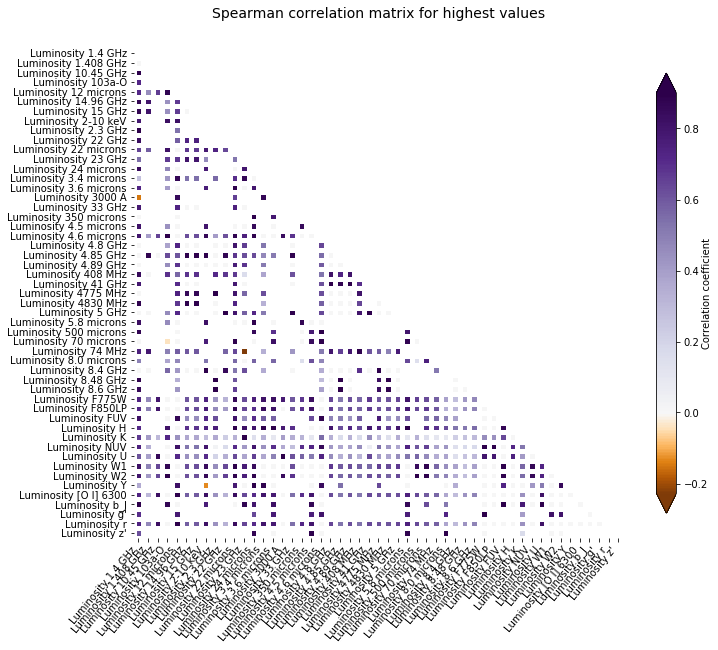

In [56]:
fig       = plt.figure(figsize=(12,9))
ax1       = fig.add_subplot(111)

cbarlabel = 'Correlation coefficient'

# Mask to only show lower triangular matrix with correlation values
mask_corr = np.triu(np.ones_like(corr.loc[cols_high_corr, cols_high_corr], dtype=bool))

# Mask values above correlation threshold (except diagonal values)
# arr_corr  = corr.loc[cols_high_corr, cols_high_corr]
# arr_corr[(arr_corr > corr_thresh) & (arr_corr < 1)] = 0
# arr_corr[(arr_corr < -corr_thresh) & (arr_corr > -1)] = 0
# Mask values above correlation threshold (including diagonal values)
arr_corr  = corr.loc[cols_high_corr, cols_high_corr].mask(mask_corr)
arr_corr[arr_corr > corr_thresh] = 0
arr_corr[arr_corr < -corr_thresh] = 0

vmin      = np.nanmin(arr_corr[arr_corr > -corr_thresh].values)
vmax      = np.nanmax(arr_corr[arr_corr < corr_thresh].values)
midpoint  = 0.0
norm      = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=midpoint)

cax       = ax1.matshow(arr_corr, cmap='PuOr', vmin=vmin, vmax=vmax, norm=norm)
cbar      = fig.colorbar(cax, shrink=.90, extend='both')
cbar.ax.set_ylabel(cbarlabel, va="bottom")

# Change visualization properties
for edge, spine in ax1.spines.items():
    spine.set_visible(False)

ticks     = np.arange(0,len(cols_high_corr.tolist()),1)
ax1.set_xticks(np.arange(corr.loc[cols_high_corr, cols_high_corr].shape[1]+1)-.5, minor=True)
ax1.set_yticks(np.arange(corr.loc[cols_high_corr, cols_high_corr].shape[0]+1)-.5, minor=True)
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(cols_high_corr, rotation=50, horizontalalignment='right')
ax1.set_yticklabels(cols_high_corr)
ax1.grid(which="minor", color="w", linestyle='-', linewidth=int(num_of_corr / 9))
ax1.tick_params(which="minor", bottom=False, left=False, top=False)
ax1.tick_params(which='major', top=False, labeltop=False, labelbottom=True)

plt.title('Spearman correlation matrix for highest values', size=14)

ax1.set_aspect('equal')

To compare these results, we can calculate the correlation matrix using Pearson's  
coefficient.

In [57]:
num_of_rows    = 18023  # Number of rows to consider. 18023 for all elements
min_elements   = 20

corr_alt       = merged_lums_catalog_df.loc[:num_of_rows].corr(min_periods=min_elements, method='pearson')
corr_alt_abs   = corr_alt.abs()

Names of the pairs of columns with the  
highest correlations (and their values).

In [58]:
cols_alt_corr  = (corr_alt_abs.where(np.triu(np.ones(corr_alt_abs.shape), k=1).astype(np.bool))  # Pairs of columns with the highest correlations
                 .stack()
                 .sort_values(ascending=False))

In [59]:
arr_alt_cols       = np.array([np.array(row) for row in cols_corr.keys()[cols_corr<corr_thresh][:num_of_corr]])  # Columns involved in the highest 25 correlations (below 0.75)
cols_high_corr_alt = np.unique(np.concatenate((arr_cols[:, 0], arr_cols[:, 1])))  # Array with individual column names from highest correlations

We can show a sample of the highly correlated pairs of columns.

In [60]:
cols_alt_corr[cols_alt_corr<corr_thresh][:num_of_corr]

Luminosity 61 GHz               Luminosity 86 GHz                 0.899866
Luminosity 2.70 GHz Effelsberg  Luminosity 8.085 GHz              0.899614
Luminosity 0.5-8 keV            Luminosity 0.5-10 keV             0.898625
Luminosity 24 microns           Luminosity W2                     0.897727
Luminosity 1.4 GHz              Luminosity 4.85 GHz               0.897585
Luminosity 5.8 microns          Luminosity FUV                    0.897547
Luminosity 24 microns           Luminosity 4.6 microns            0.897394
Luminosity H                    Luminosity 103a-E                 0.896734
Luminosity 24 microns           Luminosity W1                     0.894599
Luminosity 4.85 GHz             Luminosity 8.46 GHz               0.894425
Luminosity Y                    Luminosity F775W                  0.893501
Luminosity 2.70 GHz Effelsberg  Luminosity 8.4 GHz                0.892300
Luminosity 178 MHz              Luminosity H                      0.892237
Luminosity 33 GHz        

---

To better understand the correlation values, we can plot a correlation matrix.  
As previously mentioned, only the selected columns will be plotted for ease of reading.  
Pairs of columns with correlation values above `corr_thresh` have been set to zero ($0$).  
The matrix diagonal shows correlation coefficient value of $1.0$ since the columns are  
completely correlated with themselves.

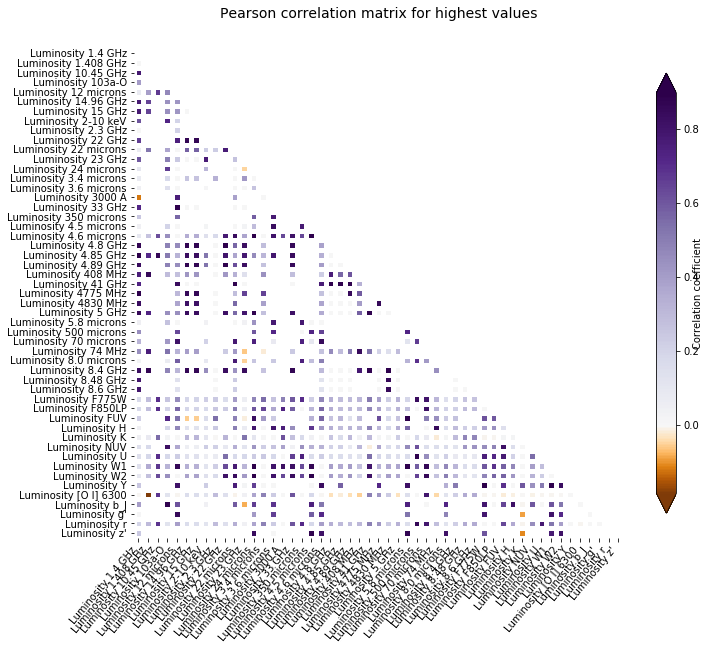

In [61]:
fig       = plt.figure(figsize=(12,9))
ax1       = fig.add_subplot(111)

cbarlabel = 'Correlation coefficient'

# Mask to only show lower triangular matrix with correlation values
mask_corr = np.triu(np.ones_like(corr_alt.loc[cols_high_corr_alt, cols_high_corr_alt], dtype=bool))

# Mask values above correlation threshold (except diagonal values)
# arr_corr  = corr.loc[cols_high_corr, cols_high_corr]
# arr_corr[(arr_corr > corr_thresh) & (arr_corr < 1)] = 0
# arr_corr[(arr_corr < -corr_thresh) & (arr_corr > -1)] = 0
# Mask values above correlation threshold (including diagonal values)
arr_corr  = corr_alt.loc[cols_high_corr_alt, cols_high_corr_alt].mask(mask_corr)
arr_corr[arr_corr > corr_thresh] = 0
arr_corr[arr_corr < -corr_thresh] = 0

vmin      = np.nanmin(arr_corr[arr_corr > -corr_thresh].values)
vmax      = np.nanmax(arr_corr[arr_corr < corr_thresh].values)
midpoint  = 0.0
norm      = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=midpoint)

cax       = ax1.matshow(arr_corr, cmap='PuOr', vmin=vmin, vmax=vmax, norm=norm)
cbar      = fig.colorbar(cax, shrink=.90, extend='both')
cbar.ax.set_ylabel(cbarlabel, va="bottom")

# Change visualization properties
for edge, spine in ax1.spines.items():
    spine.set_visible(False)

ticks     = np.arange(0,len(cols_high_corr_alt.tolist()),1)
ax1.set_xticks(np.arange(corr_alt.loc[cols_high_corr_alt, cols_high_corr_alt].shape[1]+1)-.5, minor=True)
ax1.set_yticks(np.arange(corr_alt.loc[cols_high_corr_alt, cols_high_corr_alt].shape[0]+1)-.5, minor=True)
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(cols_high_corr_alt, rotation=50, horizontalalignment='right')
ax1.set_yticklabels(cols_high_corr_alt)
ax1.grid(which="minor", color="w", linestyle='-', linewidth=int(num_of_corr / 9))
ax1.tick_params(which="minor", bottom=False, left=False, top=False)
ax1.tick_params(which='major', top=False, labeltop=False, labelbottom=True)

plt.title('Pearson correlation matrix for highest values', size=14)

ax1.set_aspect('equal')

---

# Assess blank spaces

For future calculations, and given the large amount of blank spaces seen in  
the correlation matrix plot, we also want to understand the level of sparsity of our sample.  
We use the package `missingno` to represent how many values are missing  
in our catalog.

First, we calculate the level of *completeness* (how many sources have valid measurements) of each column for the whole dataset.

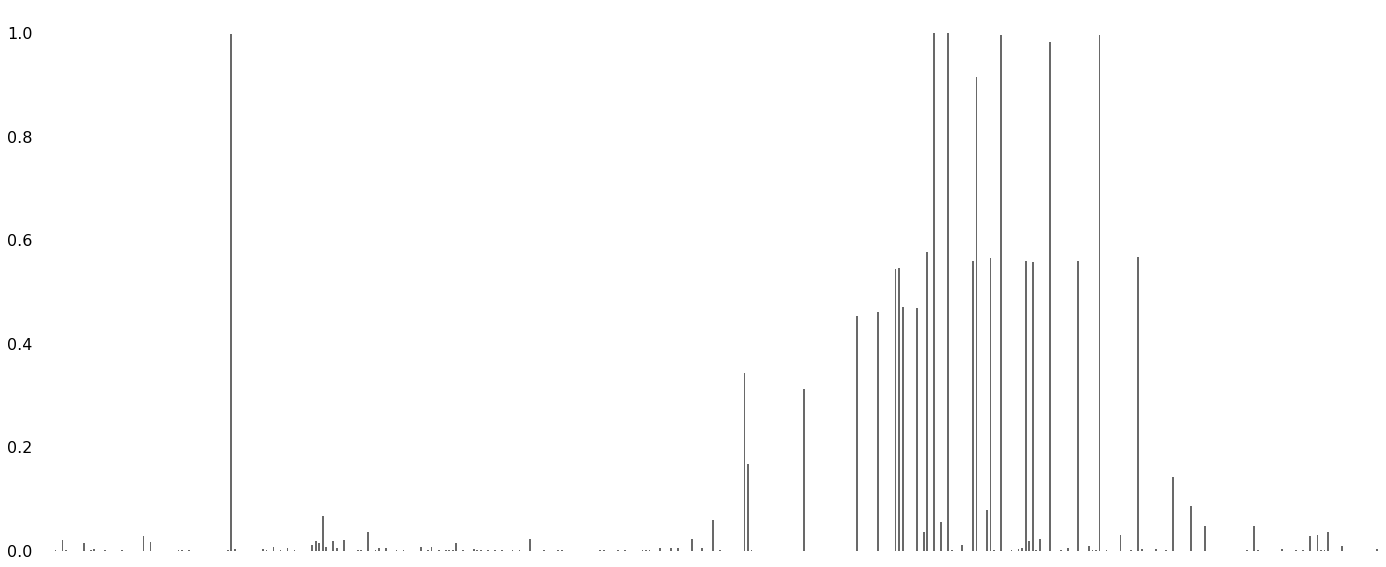

In [62]:
# msno.matrix(merged_lums_catalog_df)
msno.bar(merged_lums_catalog_df)

Now, we do it for only the most highly correlated columns.

In [63]:
used_data = pd.DataFrame(merged_lums_catalog_df[cols_high_corr])

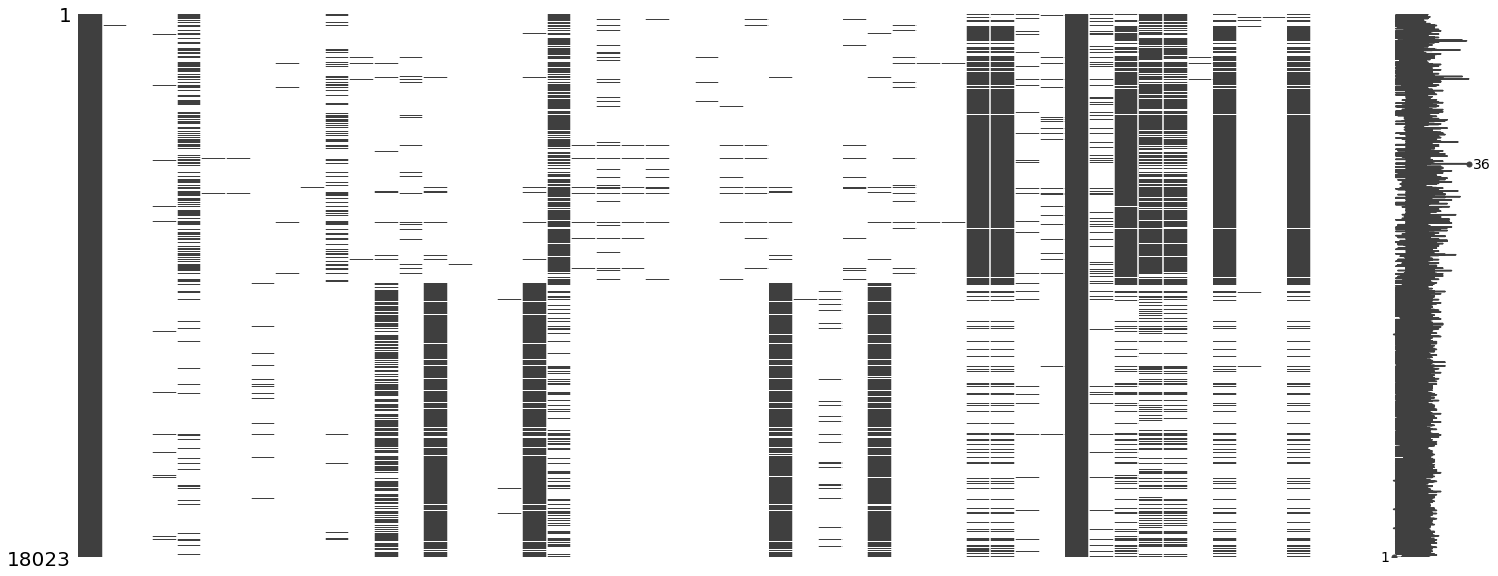

In [64]:
msno.matrix(used_data)

The right-most column in the chart shows the general shape of the data *completeness* of each selected row.  
It also points out the rows with the maximum and minimum nullity in the dataset.

This package allows us also to plot how correlated are the correlated behaviors  
of absence or presence of data for pairs of columns. A dendrogram can be plotted to  
understand any correlation in the lack of data.

In [65]:
# msno.dendrogram(merged_lums_catalog_df[cols_high_corr])

Numerically, we can also show the percentage of values in each column populated with NaN values.

For the columns with less invalid values, we have:

In [66]:
(merged_lums_catalog_df.isnull().sum()/len(merged_lums_catalog_df)*100).sort_values(ascending=True)[:25]

Luminosity J               0.016645
Luminosity K               0.016645
Luminosity 1.4 GHz         0.194196
Luminosity R               0.327359
Luminosity B               0.327359
Luminosity V               1.792154
Luminosity I               8.511347
Luminosity W1             42.334794
Luminosity U              43.167064
Luminosity F775W          43.366809
Luminosity r              44.049270
Luminosity F850LP         44.088110
Luminosity H{beta}        44.126949
Luminosity [O I] 6300     44.149143
Luminosity 4.6 microns    45.364257
Luminosity W2             45.625035
Luminosity 4.5 microns    52.982300
Luminosity 3.6 microns    53.109915
Luminosity 5.8 microns    53.919991
Luminosity 8.0 microns    54.685679
Luminosity 24 microns     65.638351
Luminosity 12 microns     68.795428
Luminosity 22 microns     83.238085
Luminosity NUV            85.840315
Luminosity 1700 A         91.410975
dtype: float64

And, for the features with the highest number of invalid entries:

In [67]:
(merged_lums_catalog_df.isnull().sum()/len(merged_lums_catalog_df)*100).sort_values(ascending=True)[-25:]

Luminosity HK'                     99.994452
Luminosity log nu(Hz) 13.934       99.994452
Luminosity [O IV]                  99.994452
Luminosity 3.7 microns             99.994452
Luminosity N4                      99.994452
Luminosity O I 11287               99.994452
Luminosity 7.9 microns Spitzer     99.994452
Luminosity H_2 S(7) line          100.000000
Luminosity 3-10 keV               100.000000
Luminosity He II 1640             100.000000
Luminosity [O III] 4960           100.000000
Luminosity 4 keV                  100.000000
Luminosity H_2 S(2) line          100.000000
Luminosity HI 7-6                 100.000000
Luminosity H_2 S(1) line          100.000000
Luminosity [S III] 18.7           100.000000
Luminosity [Ne V] 24.32           100.000000
Luminosity [Fe II] 15.99          100.000000
Luminosity H_2 S(0) line          100.000000
Luminosity [O I]                  100.000000
Luminosity 150 microns            100.000000
Luminosity 1300 microns           100.000000
Luminosity

---

# Impute empty values

Given the large proportion of empty (`NaN`) values in our dataset, we want to modify  
our table in order to make it easier to be analyzed by clustering algorithms or other type of ML codes.

Thus, we can replace non-numeric elements with some value. In this case, we choose zero ($0$) or $-99$ (as it is a very unlikely value in this context).

In [68]:
# backup_filled_lums_cat_df = filled_lums_cat_df.copy()
# filled_lums_cat_df = merged_lums_catalog_df.dropna(axis='columns', how='all')
# filled_lums_cat_df = filled_lums_cat_df.fillna(0)
# filled_lums_cat_df = filled_lums_cat_df.replace('inf', 0)

We can, also, replace the missing values with the mean of the selected column.

First, we discard columns containing less than one element.  
Some columns might have similar data (similar observational properties) and  
discarding before combining (in some way) them might have an impact in further calculations.

In [69]:
# filled_lums_cat_df = merged_lums_catalog_df.dropna(axis='columns', how='all')
filled_lums_cat_df = merged_lums_catalog_df.dropna(axis='columns', thresh=20)
col_names_non_drop = filled_lums_cat_df.columns

It is important to keep in mind that columns which have all their values as NaN  
might still have upper limits. These values have not been taken into account in this study.

Now, we replace the missing values.

In [70]:
# imputer       = SimpleImputer(missing_values=np.nan, strategy='median')
imputer       = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-99.00)
imputed_array = imputer.fit_transform(filled_lums_cat_df, filled_lums_cat_df)

Reassing the new (replaced) data into the old Table

In [71]:
filled_lums_cat_df = pd.DataFrame(imputed_array, columns=col_names_non_drop)

---

# Recreate correlation matrix

Now, we can repeat parts of the previous procedures with our data.

The option `min_elements` tells the code to obtain the correlation matrix  
only for pairs of columns with more than this number of elements in common.

In [72]:
num_of_rows      = 18023  # Number of rows to consider. 18023 for all elements
# num_of cols      = 500    # Number of columns to consider. 534 for all columns with Flux values (error columns not considered)
min_elements     = 20
# corr             = large_catalog_df[numeric_col_names[:num_of_rows]].corr(min_periods=20)
corr_filled      = filled_lums_cat_df.loc[:num_of_rows].corr(min_periods=min_elements, method='spearman')
corr_abs_filled  = corr_filled.abs()

Ordered list of highly correlated pairs of columns.

In [73]:
cols_corr_filled = (corr_abs_filled.where(np.triu(np.ones(corr_abs_filled.shape), k=1).astype(np.bool))  # Pairs of columns with the highest correlations
                 .stack()
                 .sort_values(ascending=False))

Select top pairs of columns from this new list.

In [74]:
corr_thresh      = 0.90  # We want pairs with correlations below this value (0.78, 0.98)
num_of_corr      = 50    # How many high correlations we want to analyze at a time

In [75]:
arr_cols_filled       = np.array([np.array(row) for row in cols_corr_filled.keys()[cols_corr_filled<corr_thresh][:num_of_corr]])  # Columns involved in the highest 25 correlations (below 0.75)
cols_high_corr_filled = np.unique(np.concatenate((arr_cols_filled[:, 0], arr_cols_filled[:, 1])))  # Array with individual column names from highest correlations

We can show a sample of the highly correlated pairs of columns.

In [76]:
cols_corr_filled[cols_corr_filled<corr_thresh][:num_of_corr]

Luminosity H{beta}           Luminosity U                      0.889415
Luminosity r'                Luminosity g'                     0.885166
Luminosity 500 microns       Luminosity 250 microns            0.879188
Luminosity K                 Luminosity J                      0.876645
Luminosity 500 microns       Luminosity 350 microns            0.876571
Luminosity 23 GHz            Luminosity Y                      0.874725
Luminosity [O I] 6300        Luminosity U                      0.872039
Luminosity r                 Luminosity U                      0.871728
Luminosity F775W             Luminosity U                      0.863270
Luminosity F850LP            Luminosity U                      0.863195
Luminosity 33 GHz            Luminosity 41 GHz                 0.862906
Luminosity 4.86 GHz          Luminosity 4.9 GHz                0.841171
Luminosity 250 microns       Luminosity 100 microns            0.830917
Luminosity 350 microns       Luminosity 100 microns            0

To better understand the correlation values, we can plot a correlation matrix.   
Only the selected columns will be plotted for ease of reading.  
Pairs of columns with correlation values above `corr_thresh` have been set to zero ($0$).  
The matrix diagonal shows correlation coefficient value of $1.0$ since the columns are  
completely correlated with themselves.

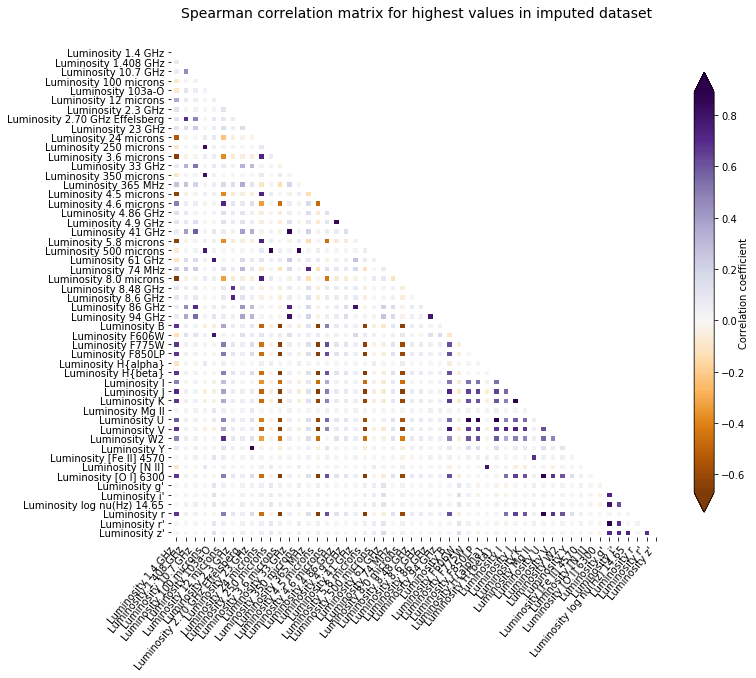

In [77]:
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)

cbarlabel = 'Correlation coefficient'

# Mask to only show lower triangular matrix with correlation values
mask_corr = np.triu(np.ones_like(corr_filled.loc[cols_high_corr_filled, cols_high_corr_filled], dtype=bool))

# Mask values above correlation threshold (except diagonal values)
# arr_corr_filled = corr_filled.loc[cols_high_corr_filled, cols_high_corr_filled]
# arr_corr_filled[(arr_corr_filled > corr_thresh) & (arr_corr_filled < 1)] = 0
# arr_corr_filled[(arr_corr_filled < -corr_thresh) & (arr_corr_filled > -1)] = 0
# Mask values above correlation threshold (including diagonal values)
arr_corr_filled = corr_filled.loc[cols_high_corr_filled, cols_high_corr_filled].mask(mask_corr)
arr_corr_filled[arr_corr_filled > corr_thresh] = 0
arr_corr_filled[arr_corr_filled < -corr_thresh] = 0


vmin      = np.nanmin(arr_corr_filled[arr_corr_filled > -1].values)
vmax      = np.nanmax(arr_corr_filled[arr_corr_filled < 1].values)
midpoint  = 0.0
norm      = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=midpoint)

cax  = ax1.matshow(arr_corr_filled, cmap='PuOr', vmin=vmin, vmax=vmax, norm=norm)
cbar = fig.colorbar(cax, shrink=.90, extend='both')
cbar.ax.set_ylabel(cbarlabel, va="bottom")

# Change visualization properties
for edge, spine in ax1.spines.items():
    spine.set_visible(False)

ticks = np.arange(0,len(cols_high_corr_filled.tolist()),1)
ax1.set_xticks(np.arange(arr_corr_filled.shape[1]+1)-.5, minor=True)
ax1.set_yticks(np.arange(arr_corr_filled.shape[0]+1)-.5, minor=True)
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(cols_high_corr_filled, rotation=50, horizontalalignment='right')
ax1.set_yticklabels(cols_high_corr_filled)
ax1.grid(which="minor", color="w", linestyle='-', linewidth=int(num_of_corr / 9))
ax1.tick_params(which="minor", bottom=False, left=False, top=False)
ax1.tick_params(which='major', top=False, labeltop=False, labelbottom=True)

plt.title('Spearman correlation matrix for highest values in imputed dataset', size=14)

ax1.set_aspect('equal')

Another change we can make is related to the position of the columns in the correlation matrix.  
It is possible to change their order to reflect possible clustering properties among  
them (using the highly correlated columns only).

In [78]:
# np.sum(corr_filled.isna())  # Number of NaN in each column

In [79]:
# corr_filled.dropna(axis='columns', how='any').dropna(axis='index', how='any')

In [80]:
X                      = corr_filled.loc[cols_high_corr_filled, cols_high_corr_filled].values
d                      = hc.distance.pdist(X)
L                      = hc.linkage(d, method='complete')
ind                    = hc.fcluster(L, 0.5*d.max(), 'distance')
ordered_columns_filled = [corr_filled[cols_high_corr_filled].columns.tolist()[i] for i in list((np.argsort(ind)))]
corr_filled_ordered    = corr_filled[cols_high_corr_filled].reindex(columns=ordered_columns_filled)
corr_filled_ordered    = corr_filled_ordered.reindex(index=ordered_columns_filled)

Now, we can replot the newly ordered correlation matrix.

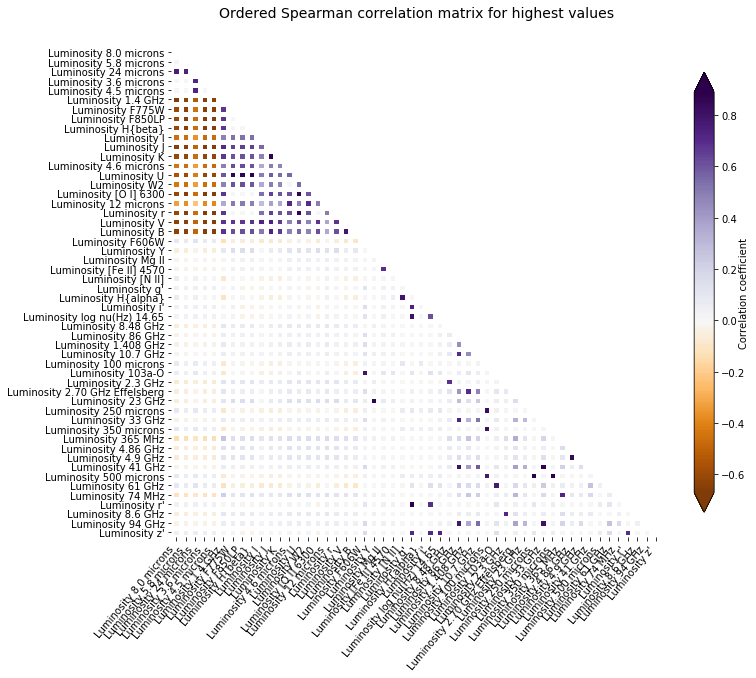

In [81]:
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)

cbarlabel = 'Correlation coefficient'

# Mask to only show lower triangular matrix with correlation values
mask_corr = np.triu(np.ones_like(corr_filled_ordered.loc[ordered_columns_filled, ordered_columns_filled], dtype=bool))

# Mask values above correlation threshold (except diagonal values)
# arr_corr_filled_ordered = corr_filled_ordered.loc[ordered_columns_filled, ordered_columns_filled]
# arr_corr_filled_ordered[(arr_corr_filled_ordered > corr_thresh) & (arr_corr_filled_ordered < 1)] = 0
# arr_corr_filled_ordered[(arr_corr_filled_ordered < -corr_thresh) & (arr_corr_filled_ordered > -1)] = 0
# Mask values above correlation threshold (including diagonal values)
arr_corr_filled_ordered = corr_filled_ordered.loc[ordered_columns_filled, ordered_columns_filled].mask(mask_corr)
arr_corr_filled_ordered[arr_corr_filled_ordered > corr_thresh] = 0
arr_corr_filled_ordered[arr_corr_filled_ordered < -corr_thresh] = 0


vmin      = np.nanmin(arr_corr_filled_ordered[arr_corr_filled_ordered > -1].values)
vmax      = np.nanmax(arr_corr_filled_ordered[arr_corr_filled_ordered < 1].values)
midpoint  = 0.0
norm      = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=midpoint)

cax  = ax1.matshow(arr_corr_filled_ordered, cmap='PuOr', vmin=vmin, vmax=vmax, norm=norm)
cbar = fig.colorbar(cax, shrink=.90, extend='both')
cbar.ax.set_ylabel(cbarlabel, va="bottom")

# Change visualization properties
for edge, spine in ax1.spines.items():
    spine.set_visible(False)

ticks = np.arange(0,len(ordered_columns_filled),1)
ax1.set_xticks(np.arange(arr_corr_filled_ordered.shape[1]+1)-.5, minor=True)
ax1.set_yticks(np.arange(arr_corr_filled_ordered.shape[0]+1)-.5, minor=True)
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(ordered_columns_filled, rotation=50, horizontalalignment='right')
ax1.set_yticklabels(ordered_columns_filled)
ax1.grid(which="minor", color="w", linestyle='-', linewidth=int(num_of_corr / 9))
ax1.tick_params(which="minor", bottom=False, left=False, top=False)
ax1.tick_params(which='major', top=False, labeltop=False, labelbottom=True)

plt.title('Ordered Spearman correlation matrix for highest values', size=14)

ax1.set_aspect('equal')

---

# Analyze feature relevance

Since the number of features our dataset has is high, we want to study their behavior  
in order to drop some of these features. Some algorithms have been developed to assess  
the importance of the information contained by each feature in the context of the overall  
behavior of the full sample.

A relevant measure of the quality of the variables (columns) we use has to do with  
their variance (or standard deviation). The differences between the variances among the columns  
should not be too high. When one column has too low variance, it does not add extra information  
to the overall table.

We can calculate the variances for all the columns.

In [82]:
order_variance        = filled_lums_cat_df.var().sort_values(ascending=False)
cols_ordered_variance = order_variance.index

Show the first $10$ elements.

In [83]:
order_variance[:10]

Luminosity Mg II           5.052533e+70
Luminosity [O III]         1.206486e+70
Luminosity H{alpha}        5.806826e+69
Luminosity [Fe II] 4570    2.099854e+69
Luminosity H{beta}         2.540628e+68
Luminosity [N II]          2.576159e+67
Luminosity [O II] 3727     2.517263e+67
Luminosity [O I] 6300      1.120553e+63
Luminosity 74 MHz          1.162283e+56
Luminosity 365 MHz         2.249352e+55
dtype: float64

Show the last $10$ elements.

In [84]:
order_variance[-10:]

Luminosity 3000 A         1.845439e+45
Luminosity z'             1.263400e+45
Luminosity 0.1-2.4 keV    2.012778e+41
Luminosity 2-10 keV       9.165690e+40
Luminosity 0.5-10 keV     6.252062e+39
Luminosity 0.2-2 keV      1.769005e+39
Luminosity 0.5-8 keV      1.274091e+39
Luminosity 0.5-4.5 keV    4.651444e+38
Luminosity 5-10 keV       2.637981e+36
Luminosity 0.1-100 GeV    6.502924e+29
dtype: float64

These results can be seen graphically with the help of the Principal Component Analysis (`PCA`) algorithm.

In [85]:
pca = PCA()
pca.fit_transform(filled_lums_cat_df)
pca_variance = pca.explained_variance_

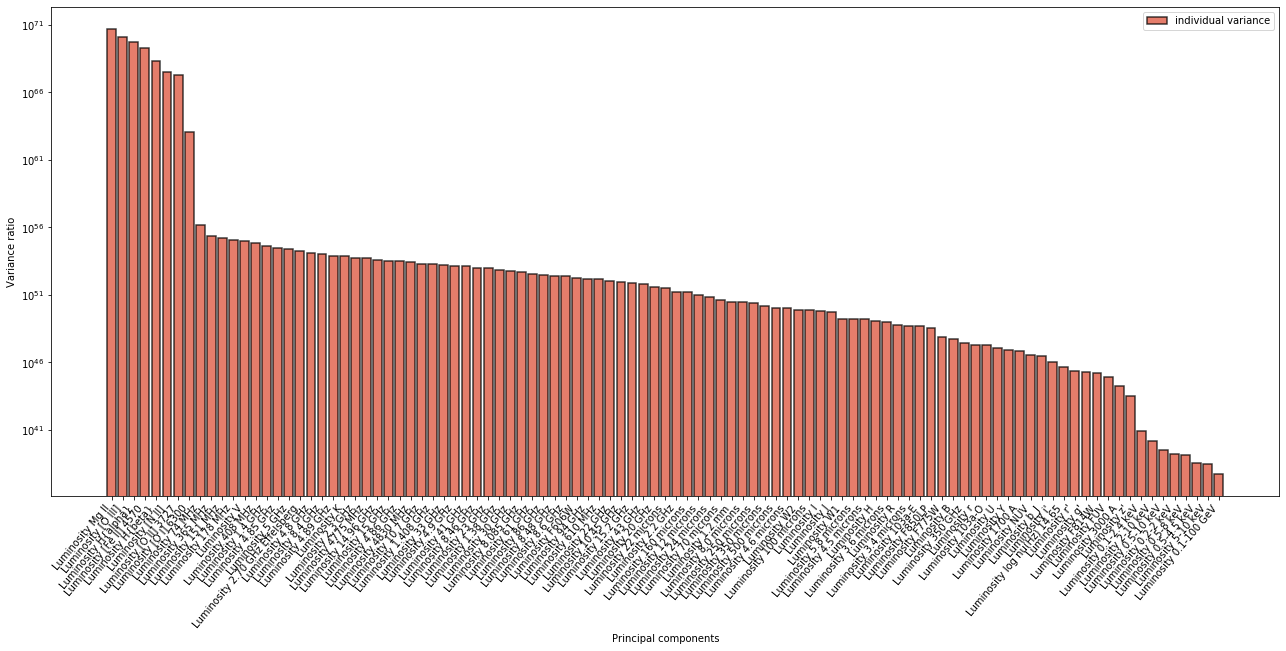

In [86]:
fig = plt.figure(figsize=(22,9))
ax1 = fig.add_subplot(111)

plt.bar(range(np.shape(cols_ordered_variance)[0]), pca_variance, alpha=0.75, align='center',\
        label='individual variance', color=colors[3], edgecolor='k', lw=1.5)
plt.legend()
ax1.set_ylabel('Variance ratio')
ax1.set_xlabel('Principal components')
ax1.set_yscale('log')
ticks = np.arange(0,len(cols_ordered_variance),1);
ax1.set_xticks(ticks);
ax1.set_xticklabels(cols_ordered_variance, rotation=50, horizontalalignment='right');

It can be seen that most of the variance of the dataset is explained by seven features.  
The rest of features show variance values orders of magnitude lower (including `Luminosity 1.4 GHz`).

---

# Remove highly correlated features

We can remove the features which do not add extra information to our dataset.  
This can be achieved taking the most highly correlated pairs of columns and  
discarding the feature with the lowest variance (i.e., the least relevant feature).

Another reason to explore these features is that they might have too similar values.  
This can be an expression of the imputation of missing values since many entries  
show the same value (if the imputation has been applied with a constant value for all columns).

In [87]:
high_corr_thresh            = 0.95

In [88]:
high_corr_pairs             = cols_corr_filled[cols_corr_filled > high_corr_thresh]  # Already discarded self correlations

In [89]:
filled_lums_clean_df        = filled_lums_cat_df.copy()

cols_high_corr_filled_clean = np.unique(high_corr_pairs.index.tolist()).tolist()

In [90]:
np.shape(cols_high_corr_filled_clean)

(21,)

In [91]:
for pair in high_corr_pairs.index.to_list():
    col_a, col_b = pair
    if col_a not in cols_high_corr_filled_clean or col_b not in cols_high_corr_filled_clean: continue
    var_a = order_variance[col_a]
    var_b = order_variance[col_b]
    if var_a < var_b:
        filled_lums_clean_df.drop(col_a, inplace=True, axis='columns')
        cols_high_corr_filled_clean.remove(col_a)
    else:
        filled_lums_clean_df.drop(col_b, inplace=True, axis='columns')
        cols_high_corr_filled_clean.remove(col_b)

In [92]:
filled_lums_clean_df.shape

(18023, 88)

In [93]:
np.shape(cols_high_corr_filled_clean)

(8,)

Thus, we have removed $13$ features from our dataset.  
Our sample now displays $88$ features.

---

# Repeat previous calculations

Now, we can obtain the correlation matrix and all its by-products  
as previously shown.

In [94]:
num_of_rows            = 18023  # Number of rows to consider. 18023 for all elements
# num_of cols            = 500    # Number of columns to consider. 534 for all columns with Flux values (error columns not considered)
min_elements           = 20
# corr                   = large_catalog_df[numeric_col_names[:num_of_rows]].corr(min_periods=20)
corr_filled_clean      = filled_lums_clean_df.loc[:num_of_rows].corr(min_periods=min_elements, method='spearman')
corr_abs_filled_clean  = corr_filled_clean.abs()

Ordered list of highly correlated pairs of columns.

In [95]:
cols_corr_filled_clean = (corr_abs_filled_clean.where(np.triu(np.ones(corr_abs_filled_clean.shape), k=1).astype(np.bool))  # Pairs of columns with the highest correlations
                 .stack()
                 .sort_values(ascending=False))

Select top pairs of columns from this new list.

In [96]:
corr_thresh      = 0.90  # We want pairs with correlations below this value (0.78, 0.98)
num_of_corr      = 50    # How many high correlations we want to analyze at a time

In [97]:
arr_cols_filled_clean       = np.array([np.array(row) for row in cols_corr_filled_clean.keys()[cols_corr_filled_clean<corr_thresh][:num_of_corr]])  # Columns involved in the highest 25 correlations (below 0.75)
cols_high_corr_filled_clean = np.unique(np.concatenate((arr_cols_filled_clean[:, 0], arr_cols_filled_clean[:, 1])))  # Array with individual column names from highest correlations

We can show a sample of the highly correlated pairs of columns.

In [98]:
cols_corr_filled_clean[cols_corr_filled_clean<corr_thresh][:num_of_corr]

Luminosity H{beta}           Luminosity U                      0.889415
Luminosity r'                Luminosity g'                     0.885166
Luminosity 500 microns       Luminosity 250 microns            0.879188
Luminosity K                 Luminosity J                      0.876645
Luminosity 23 GHz            Luminosity Y                      0.874725
Luminosity 33 GHz            Luminosity 41 GHz                 0.862906
Luminosity 4.86 GHz          Luminosity 4.9 GHz                0.841171
Luminosity 250 microns       Luminosity 100 microns            0.830917
Luminosity 41 GHz            Luminosity 86 GHz                 0.804071
Luminosity log nu(Hz) 14.65  Luminosity g'                     0.802262
Luminosity 33 GHz            Luminosity 94 GHz                 0.801259
Luminosity [N II]            Luminosity H{alpha}               0.789256
Luminosity V                 Luminosity B                      0.781276
Luminosity 86 GHz            Luminosity 94 GHz                 0

To better understand the correlation values, we can plot a correlation matrix.   
Only the selected columns will be plotted for ease of reading.  
Pairs of columns with correlation values above `corr_thresh` have been set to zero ($0$).  
The matrix diagonal shows correlation coefficient value of $1.0$ since the columns are  
completely correlated with themselves.

Change directlu the column order to reflect possible clustering properties among  
them (using the highly correlated columns only).

In [99]:
# np.sum(corr_filled.isna())  # Number of NaN in each column

In [100]:
# corr_filled.dropna(axis='columns', how='any').dropna(axis='index', how='any')

In [101]:
X_clean                      = corr_filled_clean.loc[cols_high_corr_filled_clean, cols_high_corr_filled_clean].values
d_clean                      = hc.distance.pdist(X_clean)
L_clean                      = hc.linkage(d_clean, method='complete')
ind_clean                    = hc.fcluster(L_clean, 0.5*d_clean.max(), 'distance')
ordered_columns_filled_clean = [corr_filled_clean[cols_high_corr_filled_clean].columns.tolist()[i] for i in list((np.argsort(ind_clean)))]
corr_filled_ordered_clean    = corr_filled_clean[cols_high_corr_filled_clean].reindex(columns=ordered_columns_filled_clean)
corr_filled_ordered_clean    = corr_filled_ordered_clean.reindex(index=ordered_columns_filled_clean)

Now, we can replot the newly ordered correlation matrix.

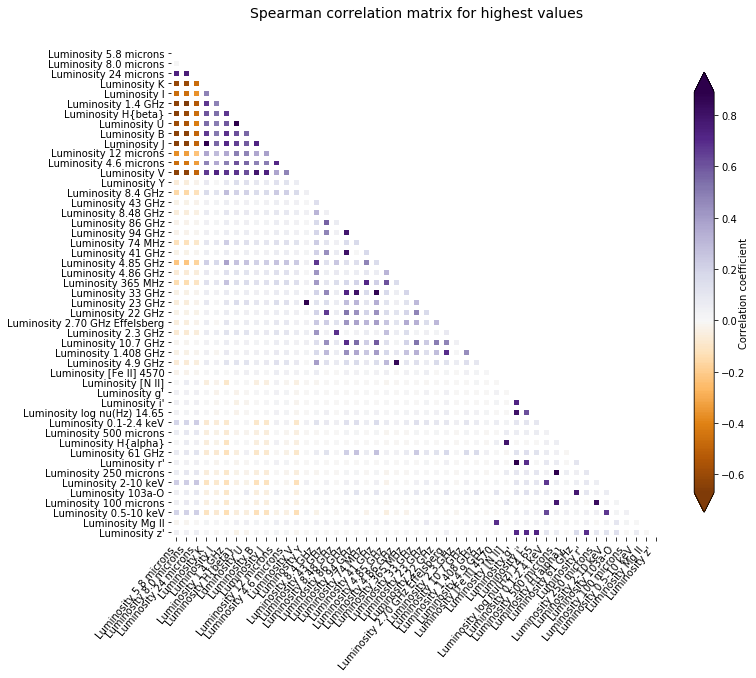

In [102]:
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)

cbarlabel = 'Correlation coefficient'

# Mask to only show lower triangular matrix with correlation values
mask_corr = np.triu(np.ones_like(corr_filled_ordered_clean.loc[ordered_columns_filled_clean, ordered_columns_filled_clean], dtype=bool))

# Mask values above correlation threshold (except diagonal values)
# arr_corr_filled_ordered = corr_filled_ordered.loc[ordered_columns_filled, ordered_columns_filled]
# arr_corr_filled_ordered[(arr_corr_filled_ordered > corr_thresh) & (arr_corr_filled_ordered < 1)] = 0
# arr_corr_filled_ordered[(arr_corr_filled_ordered < -corr_thresh) & (arr_corr_filled_ordered > -1)] = 0
# Mask values above correlation threshold (including diagonal values)
arr_corr_filled_ordered_clean = corr_filled_ordered_clean.loc[ordered_columns_filled_clean, ordered_columns_filled_clean].mask(mask_corr)
arr_corr_filled_ordered_clean[arr_corr_filled_ordered_clean > corr_thresh] = 0
arr_corr_filled_ordered_clean[arr_corr_filled_ordered_clean < -corr_thresh] = 0


vmin      = np.nanmin(arr_corr_filled_ordered_clean[arr_corr_filled_ordered_clean > -1].values)
vmax      = np.nanmax(arr_corr_filled_ordered_clean[arr_corr_filled_ordered_clean < 1].values)
midpoint  = 0.0
norm      = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=midpoint)

cax  = ax1.matshow(arr_corr_filled_ordered_clean, cmap='PuOr', vmin=vmin, vmax=vmax, norm=norm)
cbar = fig.colorbar(cax, shrink=.90, extend='both')
cbar.ax.set_ylabel(cbarlabel, va="bottom")

# Change visualization properties
for edge, spine in ax1.spines.items():
    spine.set_visible(False)

ticks = np.arange(0,len(ordered_columns_filled_clean),1)
ax1.set_xticks(np.arange(arr_corr_filled_ordered_clean.shape[1]+1)-.5, minor=True)
ax1.set_yticks(np.arange(arr_corr_filled_ordered_clean.shape[0]+1)-.5, minor=True)
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(ordered_columns_filled_clean, rotation=50, horizontalalignment='right')
ax1.set_yticklabels(ordered_columns_filled_clean)
ax1.grid(which="minor", color="w", linestyle='-', linewidth=int(num_of_corr / 9))
ax1.tick_params(which="minor", bottom=False, left=False, top=False)
ax1.tick_params(which='major', top=False, labeltop=False, labelbottom=True)

plt.title('Spearman correlation matrix for highest values', size=14)

ax1.set_aspect('equal')

Comparing that to the use of Pearson correlation values.

In [103]:
num_of_rows                = 18023  # Number of rows to consider. 18023 for all elements
# num_of cols                = 500    # Number of columns to consider. 534 for all columns with Flux values (error columns not considered)
min_elements               = 20
# corr                       = large_catalog_df[numeric_col_names[:num_of_rows]].corr(min_periods=20)
corr_filled_clean_alt      = filled_lums_clean_df.loc[:num_of_rows].corr(min_periods=min_elements, method='pearson')
corr_abs_filled_clean_alt  = corr_filled_clean_alt.abs()

Ordered list of highly correlated pairs of columns.

In [104]:
cols_corr_filled_clean_alt = (corr_abs_filled_clean_alt.where(np.triu(np.ones(corr_abs_filled_clean_alt.shape), k=1).astype(np.bool))  # Pairs of columns with the highest correlations
                 .stack()
                 .sort_values(ascending=False))

Select top pairs of columns from this new list.

In [105]:
corr_thresh      = 0.90  # We want pairs with correlations below this value (0.78, 0.98)
num_of_corr      = 50    # How many high correlations we want to analyze at a time

In [106]:
arr_cols_filled_clean_alt       = np.array([np.array(row) for row in cols_corr_filled_clean_alt.keys()[cols_corr_filled_clean_alt<corr_thresh][:num_of_corr]])  # Columns involved in the highest 25 correlations (below 0.75)
cols_high_corr_filled_clean_alt = np.unique(np.concatenate((arr_cols_filled_clean_alt[:, 0], arr_cols_filled_clean_alt[:, 1])))  # Array with individual column names from highest correlations

In [107]:
X_clean_alt                      = corr_filled_clean_alt.loc[cols_high_corr_filled_clean_alt, cols_high_corr_filled_clean_alt].values
d_clean_alt                      = hc.distance.pdist(X_clean_alt)
L_clean_alt                      = hc.linkage(d_clean_alt, method='complete')
ind_clean_alt                    = hc.fcluster(L_clean_alt, 0.5*d_clean_alt.max(), 'distance')
ordered_columns_filled_clean_alt = [corr_filled_clean_alt[cols_high_corr_filled_clean_alt].columns.tolist()[i] for i in list((np.argsort(ind_clean_alt)))]
corr_filled_ordered_clean_alt    = corr_filled_clean_alt[cols_high_corr_filled_clean_alt].reindex(columns=ordered_columns_filled_clean_alt)
corr_filled_ordered_clean_alt    = corr_filled_ordered_clean_alt.reindex(index=ordered_columns_filled_clean_alt)

Now, we can replot the newly ordered correlation matrix.

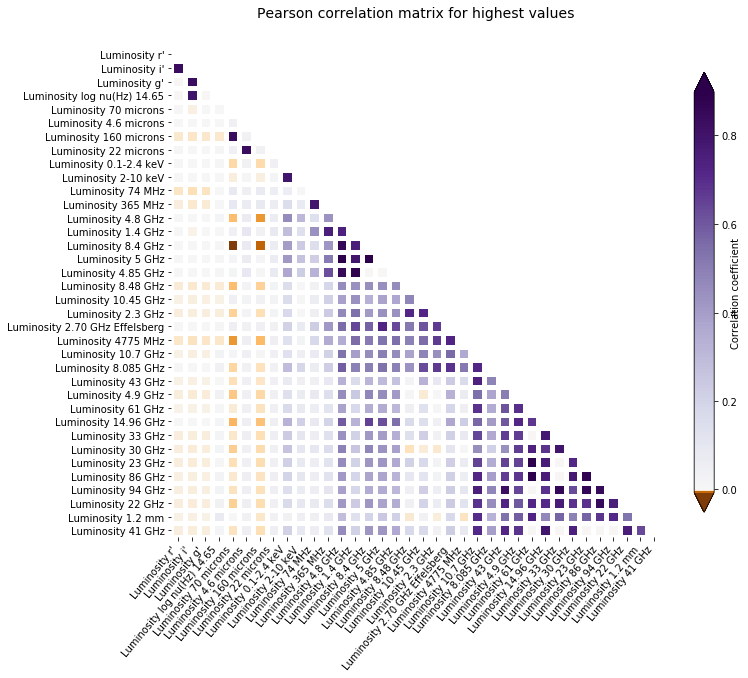

In [108]:
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)

cbarlabel = 'Correlation coefficient'

# Mask to only show lower triangular matrix with correlation values
mask_corr = np.triu(np.ones_like(corr_filled_ordered_clean_alt.loc[ordered_columns_filled_clean_alt, ordered_columns_filled_clean_alt], dtype=bool))

# Mask values above correlation threshold (except diagonal values)
# arr_corr_filled_ordered = corr_filled_ordered.loc[ordered_columns_filled, ordered_columns_filled]
# arr_corr_filled_ordered[(arr_corr_filled_ordered > corr_thresh) & (arr_corr_filled_ordered < 1)] = 0
# arr_corr_filled_ordered[(arr_corr_filled_ordered < -corr_thresh) & (arr_corr_filled_ordered > -1)] = 0
# Mask values above correlation threshold (including diagonal values)
arr_corr_filled_ordered_clean_alt = corr_filled_ordered_clean_alt.loc[ordered_columns_filled_clean_alt, ordered_columns_filled_clean_alt].mask(mask_corr)
arr_corr_filled_ordered_clean_alt[arr_corr_filled_ordered_clean_alt > corr_thresh] = 0
arr_corr_filled_ordered_clean_alt[arr_corr_filled_ordered_clean_alt < -corr_thresh] = 0


vmin      = np.nanmin(arr_corr_filled_ordered_clean_alt[arr_corr_filled_ordered_clean_alt > -1].values)
vmax      = np.nanmax(arr_corr_filled_ordered_clean_alt[arr_corr_filled_ordered_clean_alt < 1].values)
midpoint  = 0.0
norm      = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=midpoint)

cax  = ax1.matshow(arr_corr_filled_ordered_clean_alt, cmap='PuOr', vmin=vmin, vmax=vmax, norm=norm)
cbar = fig.colorbar(cax, shrink=.90, extend='both')
cbar.ax.set_ylabel(cbarlabel, va="bottom")

# Change visualization properties
for edge, spine in ax1.spines.items():
    spine.set_visible(False)

ticks = np.arange(0,len(ordered_columns_filled_clean_alt),1)
ax1.set_xticks(np.arange(arr_corr_filled_ordered_clean_alt.shape[1]+1)-.5, minor=True)
ax1.set_yticks(np.arange(arr_corr_filled_ordered_clean_alt.shape[0]+1)-.5, minor=True)
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(ordered_columns_filled_clean_alt, rotation=50, horizontalalignment='right')
ax1.set_yticklabels(ordered_columns_filled_clean_alt)
ax1.grid(which="minor", color="w", linestyle='-', linewidth=int(num_of_corr / 9))
ax1.tick_params(which="minor", bottom=False, left=False, top=False)
ax1.tick_params(which='major', top=False, labeltop=False, labelbottom=True)

plt.title('Pearson correlation matrix for highest values', size=14)

ax1.set_aspect('equal')

---

# Clustering calculations

As a way to extend our analysis, we can construct, and plot, the dendrogram for our data.  
This tool can be useful to determine possible clustering among the columns.

We are going to use the table with imputed values and with highly correlated features removed.

In [109]:
# generate the linkage matrix
Z = hc.linkage(filled_lums_clean_df, 'ward')

We plot a reduced version of the dendrogram.

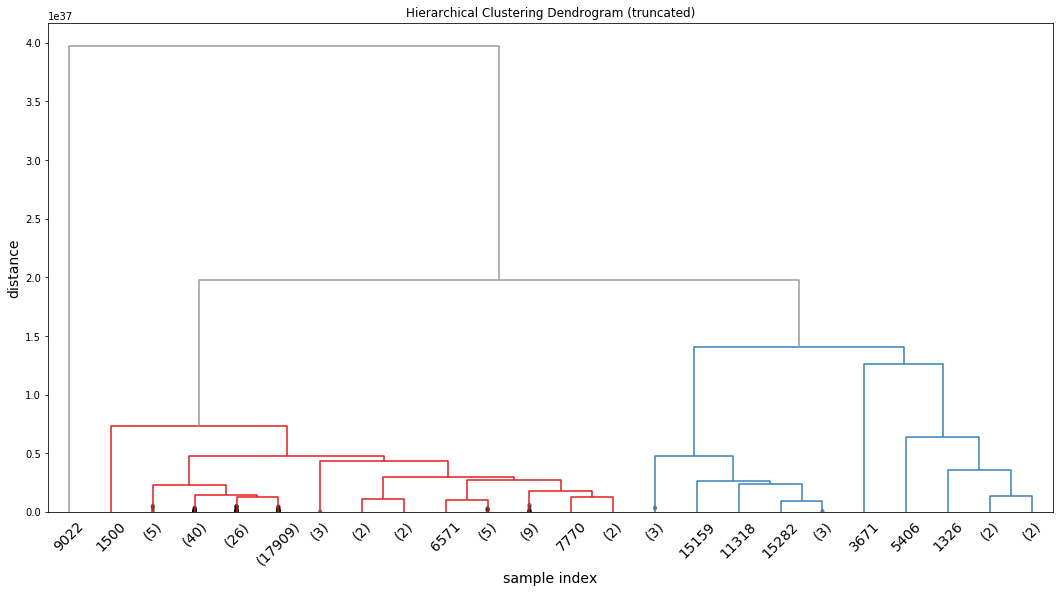

In [110]:
fig = plt.figure(figsize=(18,9))
ax1 = fig.add_subplot(111)

# Custom color for branches
cmap_use   = cm.get_cmap('Set1')
cmap_array = cmap_use(np.linspace(0, 1, 10))
hc.set_link_color_palette([mcolors.rgb2hex(rgb[:3]) for rgb in cmap_array])

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index', size=14)
plt.ylabel('distance', size=14)
hc.dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=24,  # show only the last p merged clusters
    show_leaf_counts=True,  # otherwise numbers in brackets are counts
    # leaf_rotation=90.,
    color_threshold =1.5e37,
    above_threshold_color=cmap_use(1.0),  # color of first link
    leaf_font_size=14.,
    show_contracted=True,  # to get a distribution impression in truncated branches
    orientation='top'
)

#plt.xscale('log')
plt.show()

# hc.set_link_color_palette(None)  # Reset color values

One conclusion that can be drawn from the previous dendrogram is related to  
the fact that the most part of our sample is shown as part of one major cluster  
and the remaining elements are depicted as, mostly, outliers.

Another option to find possible clusters within our data is using `t-SNE`  
(t-distributed Stochastic Neighbor Embedding, **van der Maaten and Hinton, 2008**) algorithms.  
A good guide for its use can be found in [https://distill.pub/2016/misread-tsne/](https://distill.pub/2016/misread-tsne/).

In [111]:
X_tsne = TSNE(learning_rate=100, perplexity=35, n_iter=1500).fit_transform(filled_lums_clean_df)

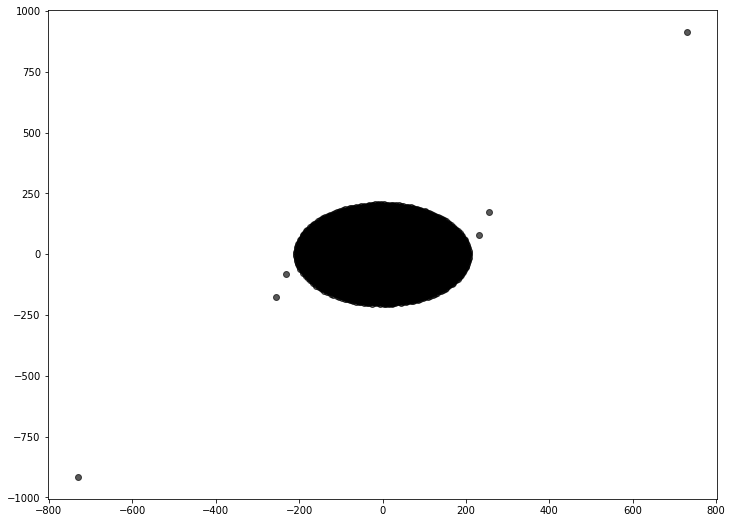

In [112]:
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)

ax1.scatter(X_tsne[:, 0], X_tsne[:, 1], c='k', alpha=0.65)

As with the results from the creation of the dendrogram, we can see that most of  
the elements of our sample gather into one major cluster and the remaining elements  
are depicted as outliers.

It is important to note that, in principle, distances between points do not hold any  
particular meaning. What is important is the overall distribution of elements.  
And

---

# Obtain elements of clusters

From the previous dendrogram and the `t-SNE` plot, we can see that we have two distinct populations for our sample.  
With this number ($2$), we can use Agglomerative Clustering from `sklearn` to obtain the labels  
for our sources.

In [113]:
# max_d         = 0.5e29
max_d         = 1.5e37

In [114]:
cluster_agg   = AgglomerativeClustering(n_clusters=None, distance_threshold=max_d, affinity='euclidean', linkage='ward')  
agg_cluster   = cluster_agg.fit_predict(filled_lums_clean_df)

In [115]:
array_values_agg = []
for cluster_idx in np.unique(agg_cluster):
    array_values_agg.append([cluster_idx, np.sum(agg_cluster == (cluster_idx))])
array_values_agg = np.array(array_values_agg)

In [116]:
ordered_array_values_agg = array_values_agg[array_values_agg[:,1].argsort()[::-1]]

In [117]:
for cluster_idx in ordered_array_values_agg[:25]:
    print(f'Cluster id: {cluster_idx[0]}\tElements: {cluster_idx[1]}')

Cluster id: 2	Elements: 18006
Cluster id: 0	Elements: 16
Cluster id: 1	Elements: 1


We can also fetch the values from the previous execution of the Dendrogram calculation.

In [118]:
clusters_dend = hc.fcluster(Z, max_d, criterion='distance')

In [119]:
array_values_dend = []
for cluster_idx in np.unique(clusters_dend):
    array_values_dend.append([cluster_idx, np.sum(clusters_dend == (cluster_idx))])
array_values_dend = np.array(array_values_dend)

In [120]:
ordered_array_values_dend = array_values_dend[array_values_dend[:,1].argsort()[::-1]]

In [121]:
for cluster_idx in ordered_array_values_dend[:25]:
    print(f'Cluster id: {cluster_idx[0]}\tElements: {cluster_idx[1]}')

Cluster id: 1	Elements: 18006
Cluster id: 2	Elements: 16
Cluster id: 3	Elements: 1


Thus, we can see that the results from both methods deliver the same results. There is one large cluster with more than $99 \%$ of the elements from the full sample. And the rest is shared among several minor clusters which could be classified as *outliers*.

---